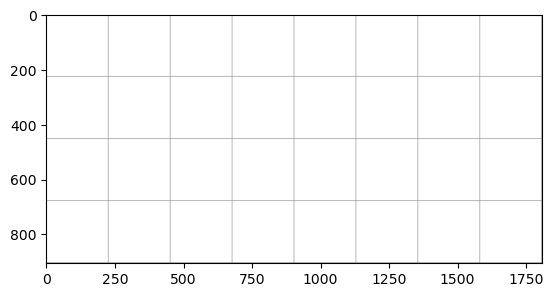

F     F     G     F     F     F     F     F     F     F     G     G     F     F     G     F     G     G     G     G     G     F     F     G     F     F     G     G     F     F     G     G    


 12%|█▏        | 36/304 [41:44<24:33:17, 329.84s/it]

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from random import *
from tqdm.notebook import tqdm, trange
from time import sleep
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from warnings import filterwarnings
filterwarnings('ignore')

  
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    plt.savefig('labels.JPG')
    
    
batch_size = 32
num_classes = 10
learning_rate = 0.01
num_epochs = 2


train_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
        )
])
test_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

from torchvision.datasets import ImageFolder
from torchvision.datasets import ImageFolder
train_folder = ImageFolder("D:\SPRING 2023\CyberGIS and Big Data_INES_8090_G02\Class Project\FINAL\GeoTIFF", transform=train_trans , )
val_folder = ImageFolder("D:\SPRING 2023\CyberGIS and Big Data_INES_8090_G02\Class Project\FINAL\GeoTIFF", transform=train_trans , )
test_folder= ImageFolder("D:\SPRING 2023\CyberGIS and Big Data_INES_8090_G02\Class Project\FINAL\GeoTIFF", transform=test_trans, )


len(train_folder.classes)

classes = (train_folder.classes)

# Splitting data on batches
train_loader = torch.utils.data.DataLoader(train_folder, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_folder, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_folder, shuffle=False, batch_size=batch_size)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


model = models.vgg19(pretrained=True)

## https://discuss.pytorch.org/t/how-to-modify-a-pretrained-model/60509/12
def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

replace_layers(model.features, nn.ReLU, nn.LeakyReLU())
replace_layers(model.classifier, nn.ReLU, nn.Softmax())

model.classifier[6] = nn.Linear(4096, 7) # original model has outputs for 1000 classes. 


# Freezing all layers except last 15
#for param in list(model.parameters())[:-15]:
 #   param.requires_grad = False

    
## Defining model optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-4)

def mean(l: list):
    return sum(l) / len(l)

from sklearn.metrics import accuracy_score

def plot_losses_and_acc(train_losses, train_accuracies, valid_losses, valid_accuracies): 
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].plot(train_losses, label='train_losses')
    axes[0].plot(valid_losses, label='valid_losses')
    axes[0].set_title('Losses')
    axes[0].legend()
    plt.savefig("Loss in combination 1.JPG")
    
    axes[1].plot(train_accuracies, label='train_losses')
    axes[1].plot(valid_accuracies, label='valid_losses')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    plt.savefig("Accuracy in combination 1.JPG")
    
def validate(model, valid_data, loss_fn):
    valid_losses, valid_accuracies = [], []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(valid_data, leave=False):
            X_batch, y_batch = X_batch.float(), y_batch.long()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            valid_losses.append(loss.item())
            preds = torch.argmax(logits, axis=1)
            
            valid_accuracies.append(((preds == y_batch).sum() / len(preds)).item())
    return mean(valid_losses), mean(valid_accuracies)
    

def train(model, train_data, valid_data, loss_fn, opt, epoches):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    
    for epoch in tqdm(range(epoches)):
        train_loss = []
        train_acc = []
        model.train()
        for X_batch, y_batch in tqdm(train_data, leave=False):
            opt.zero_grad()

            X_batch, y_batch = X_batch.float(), y_batch.long()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch,)
            train_loss.append(loss.item())

            pred = torch.argmax(logits, dim=1)
            train_acc.append(((pred == y_batch).sum() / len(pred)).item())
            loss.backward()
            opt.step()

        valid_loss, valid_accuracy = validate(model, valid_data, loss_fn)

        train_accuracies.append(mean(train_acc))
        train_losses.append(mean(train_loss))
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'epoch: {epoch}: train_loss: {mean(train_losses)}, train_acc: {mean(train_acc)}, val_loss: {valid_loss}, val_acc: {valid_accuracy}')
    plot_losses_and_acc(train_losses, train_accuracies, valid_losses, valid_accuracies)
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies


from tqdm import tqdm

model, train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, train_loader, val_loader, loss_fn, opt, epoches=num_epochs)

# resource: #https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## loss calculation

valid_loss, valid_acc = validate(model, test_loader, loss_fn)

print(valid_loss, valid_acc)

##Testing

dataiter = iter(test_loader)
images, labels = next(dataiter)

# resource: #https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

#Save model
PATH = './VGG19New.pth'
torch.save(model.state_dict(), PATH)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


##Let us look at how the network performs on the whole dataset.

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# prepare to count predictions for each class on iphone image data
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed because we already trained
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')